<a href="https://colab.research.google.com/github/sreeya21/Toxic-Comment-Classifier/blob/main/Toxic_Comment_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/3
250/250 [==============================] - 63s 225ms/step - loss: 0.2214 - accuracy: 0.4308 - val_loss: 0.1263 - val_accuracy: 0.9942
Epoch 2/3
250/250 [==============================] - 53s 212ms/step - loss: 0.1059 - accuracy: 0.6503 - val_loss: 0.0801 - val_accuracy: 0.9940
Epoch 3/3
1/1 [==============================] - 0s 31ms/step


<Figure size 800x500 with 0 Axes>

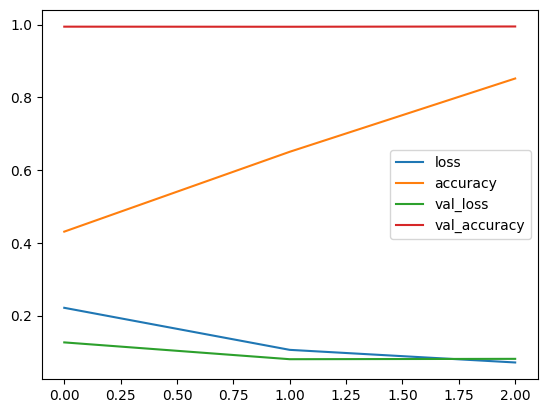

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://316fb43b52746bd149.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [12]:
!pip install pandas
!pip install matplotlib
import gradio as gr
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load and preprocess data
data = pd.read_csv('/train.csv')
data = data.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset

# Use a smaller subset for quick testing (adjust as needed)
data = data.sample(n=20000, random_state=42)

X = data['comment_text'].values

# Assuming 'toxic', 'severe_toxic', etc. are present in the dataset
if {'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'}.issubset(data.columns):
    y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
else:
    # Handle the case where the expected columns are not found
    print("Error: Expected toxicity columns not found in the dataset.")
    # Create dummy columns with all values as 0
    data['toxic'] = 0
    data['severe_toxic'] = 0
    data['obscene'] = 0
    data['threat'] = 0
    data['insult'] = 0
    data['identity_hate'] = 0
    y = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Tokenize and pad sequences
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=max_len)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')  # Output layer with 6 nodes for 6 labels
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model (adjust epochs and batch size as needed)
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_val, y_val))

# Plot training history
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# Function to score comment
def score_comment(comment):
    sequence = tokenizer.texts_to_sequences([comment])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    results = model.predict(padded_sequence)

    text = ''
    for idx, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        text += '{}: {}\n'.format(col, results[0][idx] > 0.5)

    return text

# Create the Gradio interface
iface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=5, placeholder="Enter your comment here..."),
    outputs="text",
    title="Toxicity Detection App",
    description="Enter a comment to check its toxicity levels."
)

# Launch the interface
iface.launch()